
--- Finding best K and weights ---
Best K: 22
Best Weights: uniform
Best Test Accuracy: 0.78



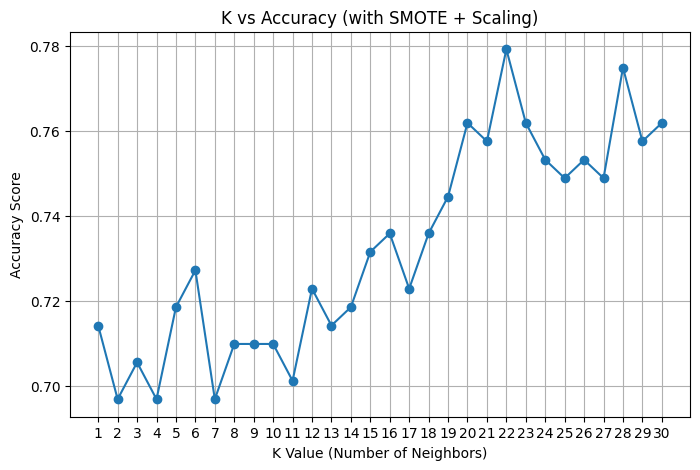

--- Results for Best Model ---
Confusion Matrix:
 [[117  33]
 [ 18  63]]

Accuracy: 0.78
Precision: 0.66
Recall: 0.78


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("diabetes.csv")

# Replace medically impossible zeros with median values
cols_with_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_with_zero:
    df[col] = df[col].replace(0, df[col].median())

# Separate features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Apply SMOTE to the training data ONLY
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# --- NEW: Find the best K and weights + store accuracy for visualization ---
print("\n--- Finding best K and weights ---")
best_acc = 0.0
best_k = 0
best_weights = ''

k_range = range(1, 31)  # Test k values from 1 to 30
k_values = []
accuracies = []

for k in k_range:
    for weights_option in ['uniform', 'distance']:
        knn = KNeighborsClassifier(n_neighbors=k, weights=weights_option)
        knn.fit(X_train_res, y_train_res)
        y_pred = knn.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        
        # Track best model
        if acc > best_acc:
            best_acc = acc
            best_k = k
            best_weights = weights_option
    
    # Store accuracy for plot (using uniform for consistency)
    knn_temp = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_temp.fit(X_train_res, y_train_res)
    y_temp_pred = knn_temp.predict(X_test)

    k_values.append(k)
    accuracies.append(accuracy_score(y_test, y_temp_pred))

print(f"Best K: {best_k}")
print(f"Best Weights: {best_weights}")
print(f"Best Test Accuracy: {best_acc:.2f}\n")

# --- Visualization: Accuracy vs K ---
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("K Value (Number of Neighbors)")
plt.ylabel("Accuracy Score")s
plt.title("K vs Accuracy (with SMOTE + Scaling)")
plt.xticks(k_values)
plt.grid(True)
plt.show()
# --- End Visualization ---


# --- Train the best model found ---
knn_best = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights)
knn_best.fit(X_train_res, y_train_res)

# Predictions (on the original, un-resampled test set)
y_pred = knn_best.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("--- Results for Best Model ---")
print("Confusion Matrix:\n", cm)
print(f"\nAccuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")